#HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

##[TO COMPLETE] Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the Encoder, and the Decoder.
Let's start by the Encoder that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. Specifically, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[To complete]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.


In [ ]:
class Sampling(tf.keras.layers.Layer):
    
    def call(self, inputs):   
      z_mean, z_sigma = inputs
      epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0],tf.shape(z_mean)[1]))
      z = z_mean + tf.exp(z_sigma/2) * epsilon
      return z

##[TO COMPLETE] Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW5), and then use the obtained encoding to compute z_mean and z_var, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the latent_dim (that is the dimension of $z$) to 2. This choice is made to make possible to represent the results easily.

**[TO COMPLETE]**: complete the code defining a deep encoder and the Dense layers that model z_mean and z_var. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. (Insert motivations about your choice into cells immediately below this one.)

In [ ]:
latent_dim = 2
from tensorflow.keras import layers

encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = layers.Dense(256, activation="relu")(encoder_inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)

z_mean =  layers.Dense(units = latent_dim, name = "z_mean")(x)
z_var =  layers.Dense(latent_dim, name = "z_var")(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 256)          200960      input_11[0][0]                   
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 128)          32896       dense_30[0][0]                   
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 64)           8256        dense_31[0][0]                   
____________________________________________________________________________________________

The number of layer is 3 (as requested by the instructions) with the addition of other two dense layers to compute z_mean and z_var. The number of units of the first one is 256 and then it is halved for each subsequent layer. The number of hidden neurons was chosen to
obtain reasonably low loss while keeping
the network reasonably small (referred to the last encoder layer which has a relatively small number of units compared to the starting data size, 64). Also the number of units of middle layers has been chosen with halving operation in order to obtain a value between the ones of the previous and the next layers

As usual standard for deep networks the activation function for the hidden layers is Relu in order to obtain easier optimization
(I tried to replace the rectified linear units with 
sigmoi activation function but it did not significantly affect the results).

##[TO COMPLETE] Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. 2 layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

**[TO COMPLETE]**: define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer).

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(latent_inputs)
x = layers.Dense(256, activation="relu")(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_34 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_35 (Dense)             (None, 784)               201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


The number of layers il again 3 and the number of units is the same as the encoder but in reverse order since the decoder architecture has to be specular to the encoder one.
Again the activation function for the hidden layers is Relu, except for the output layer where the sigmoid is used: it allows us to use binary crossentropy loss when computing the reconstruction loss.

##[TO COMPLETE] Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**[TO COMPLETE]** implement the reconstruction loss and the KL-loss.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            reconstruction_loss = keras.losses.binary_crossentropy(data, reconstruction)*x_train.shape[1]
            kl_loss = 0.5 * keras.backend.sum(keras.backend.square(z_mean) + keras.backend.exp(z_var) - z_var - 1, axis = -1)
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, x_train, epochs=30, batch_size=80)

Epoch 1/30
625/625 [==============================] - 8s 12ms/step - loss: 190.9906 - reconstruction_loss: 186.0134 - kl_loss: 4.9771
Epoch 2/30
625/625 [==============================] - 7s 11ms/step - loss: 167.3206 - reconstruction_loss: 162.5721 - kl_loss: 4.7484
Epoch 3/30
625/625 [==============================] - 7s 11ms/step - loss: 161.2250 - reconstruction_loss: 156.0441 - kl_loss: 5.1809
Epoch 4/30
625/625 [==============================] - 7s 11ms/step - loss: 157.0841 - reconstruction_loss: 151.5749 - kl_loss: 5.5092
Epoch 5/30
625/625 [==============================] - 7s 11ms/step - loss: 154.5458 - reconstruction_loss: 148.8838 - kl_loss: 5.6619
Epoch 6/30
625/625 [==============================] - 7s 11ms/step - loss: 152.5832 - reconstruction_loss: 146.7800 - kl_loss: 5.8032
Epoch 7/30
625/625 [==============================] - 7s 11ms/step - loss: 151.0653 - reconstruction_loss: 145.1506 - kl_loss: 5.9147
Epoch 8/30
625/625 [==============================] - 7s 11ms/

##[TO COMPLETE] Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

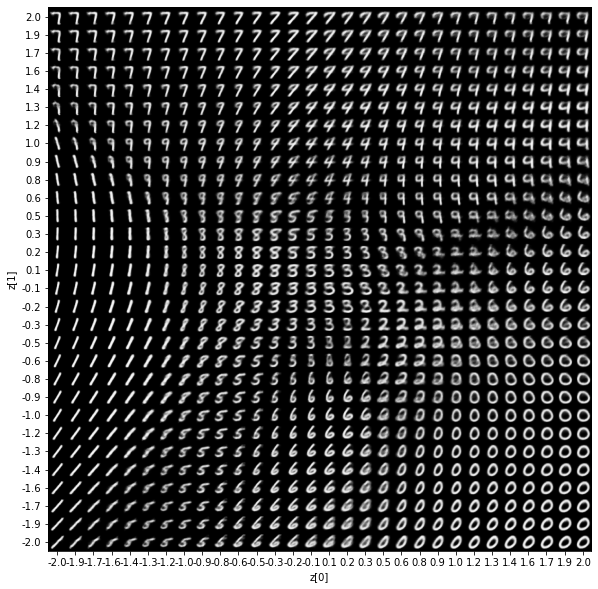

In [ ]:
def plot_latent(encoder, decoder, scale = 2.0, n = 30, figsize = 10):
     
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 30) 

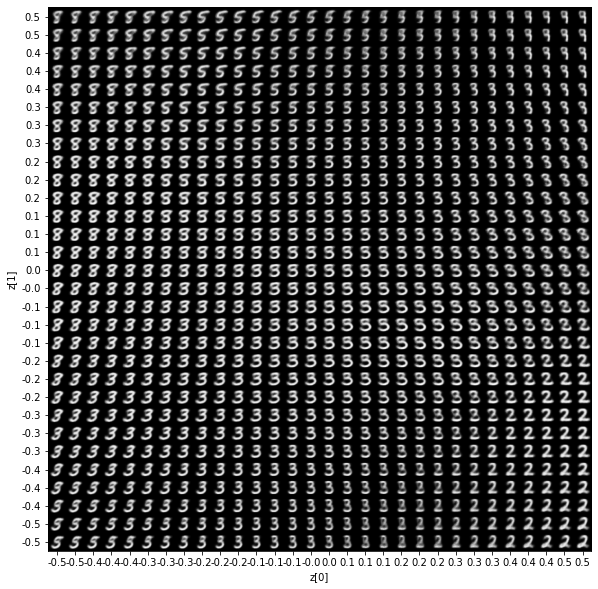

In [ ]:
plot_latent(encoder, decoder, 0.5, 30) 

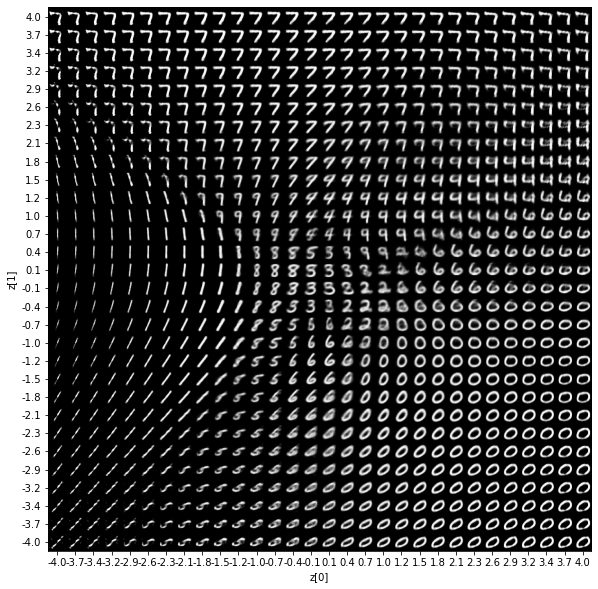

In [ ]:
plot_latent(encoder, decoder, 4, 30) 

Let's finally check how the various digits have been rapresented in the latent space by the VAE.

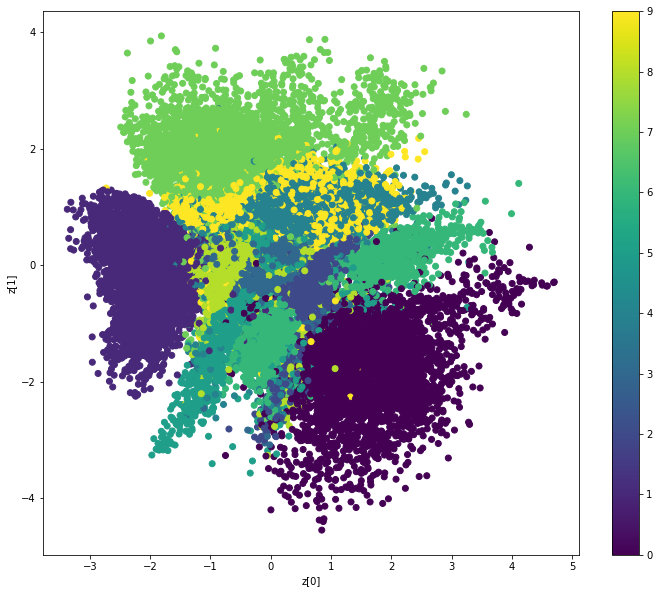

In [ ]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**[TO COMPLETE]** Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.

Exploring the scale of plots of generated data it is possible to see that:

-for low scale the range of the representation is always centered in0 but smaller, for this reason some some periferical areas are not represented (in fact some numbers are not present, such as 6, 5, 1 and 0), thusthere is less variation, more continuity but there are also many blurred data (completness problem).

-for high scale  arise problems of continuity: around the origin neighbour data are often very different.

It has a correspondence in the last plot, in fact the issues are located where in latent space there are no compact and homogeneous regions. Where there are defined clusters it is maintained the similarity of nearby encodings on the local scale and the samples result to be meaningful. It is not the case of areas where latent samples are very densely packed but without homogeneus labels, for example close to (1, 1)


Below I tested 3 similar VAEs with some differend hyper-parameters (first one with doubled number of units, than with one less hidden layer and the last one with one more hidden layer).

In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = layers.Dense(512, activation="relu")(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
z_mean =  layers.Dense(units = latent_dim, name = "z_mean")(x)
z_var =  layers.Dense(latent_dim, name = "z_var")(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(512, activation="relu")(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

print("Number of encoder parameters: ", encoder.count_params())
print("Number of decoder parameters: ", decoder.count_params())

Number of encoder parameters:  566660
Number of decoder parameters:  534544


In [ ]:
vae_2 = VAE(encoder, decoder)
vae_2.compile(optimizer=keras.optimizers.Adam())
vae_2.fit(x_train, x_train, epochs=30, batch_size=80)

Epoch 1/30
625/625 [==============================] - 13s 20ms/step - loss: 184.0592 - reconstruction_loss: 179.3655 - kl_loss: 4.6937
Epoch 2/30
625/625 [==============================] - 13s 20ms/step - loss: 159.6582 - reconstruction_loss: 154.3265 - kl_loss: 5.3317
Epoch 3/30
625/625 [==============================] - 13s 20ms/step - loss: 154.7108 - reconstruction_loss: 149.0927 - kl_loss: 5.6181
Epoch 4/30
625/625 [==============================] - 12s 20ms/step - loss: 151.9127 - reconstruction_loss: 146.1064 - kl_loss: 5.8063
Epoch 5/30
625/625 [==============================] - 12s 20ms/step - loss: 149.6918 - reconstruction_loss: 143.7422 - kl_loss: 5.9496
Epoch 6/30
625/625 [==============================] - 12s 20ms/step - loss: 148.0007 - reconstruction_loss: 141.9196 - kl_loss: 6.0811
Epoch 7/30
625/625 [==============================] - 13s 20ms/step - loss: 146.9487 - reconstruction_loss: 140.8076 - kl_loss: 6.1410
Epoch 8/30
625/625 [==============================] - 1

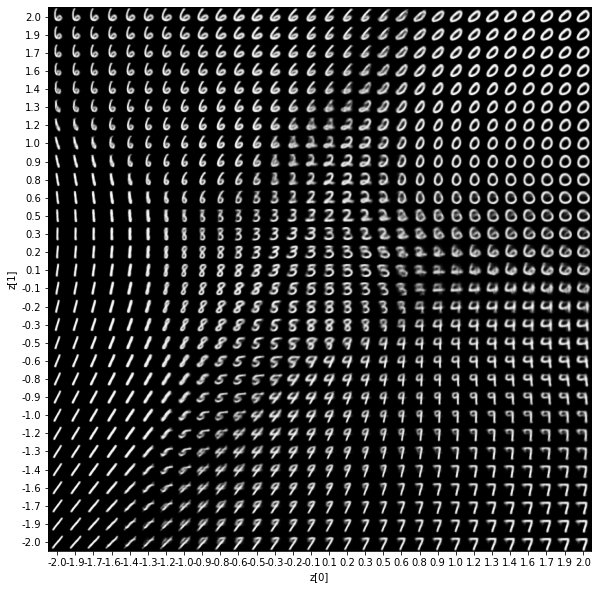

In [ ]:
plot_latent(encoder, decoder, 2.0, 30) 

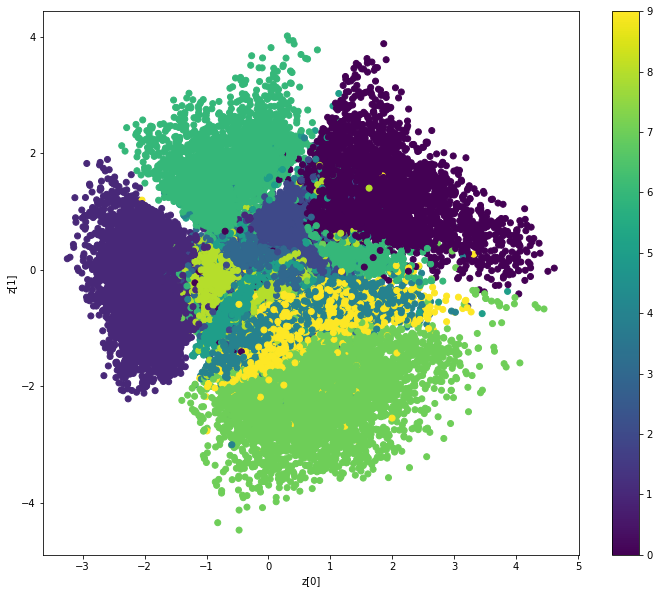

In [ ]:
plot_label_clusters(encoder, decoder, x_train, y_train)

In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = layers.Dense(256, activation="relu")(encoder_inputs)
x = layers.Dense(64, activation="relu")(x)
z_mean =  layers.Dense(units = latent_dim, name = "z_mean")(x)
z_var =  layers.Dense(latent_dim, name = "z_var")(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")


print("Number of encoder parameters: ", encoder.count_params())
print("Number of decoder parameters: ", decoder.count_params())

Number of encoder parameters:  217668
Number of decoder parameters:  202256


In [ ]:
vae_3 = VAE(encoder, decoder)
vae_3.compile(optimizer=keras.optimizers.Adam())
vae_3.fit(x_train, x_train, epochs=30, batch_size=80)

Epoch 1/30
625/625 [==============================] - 7s 10ms/step - loss: 197.9805 - reconstruction_loss: 189.9964 - kl_loss: 7.9841
Epoch 2/30
625/625 [==============================] - 6s 10ms/step - loss: 169.9547 - reconstruction_loss: 165.0343 - kl_loss: 4.9205
Epoch 3/30
625/625 [==============================] - 6s 10ms/step - loss: 166.2321 - reconstruction_loss: 161.2257 - kl_loss: 5.0063
Epoch 4/30
625/625 [==============================] - 6s 10ms/step - loss: 164.0183 - reconstruction_loss: 158.8964 - kl_loss: 5.1219
Epoch 5/30
625/625 [==============================] - 6s 10ms/step - loss: 162.3752 - reconstruction_loss: 157.1544 - kl_loss: 5.2208
Epoch 6/30
625/625 [==============================] - 6s 10ms/step - loss: 161.1695 - reconstruction_loss: 155.8680 - kl_loss: 5.3016
Epoch 7/30
625/625 [==============================] - 6s 10ms/step - loss: 160.1198 - reconstruction_loss: 154.7479 - kl_loss: 5.3718
Epoch 8/30
625/625 [==============================] - 6s 10ms/

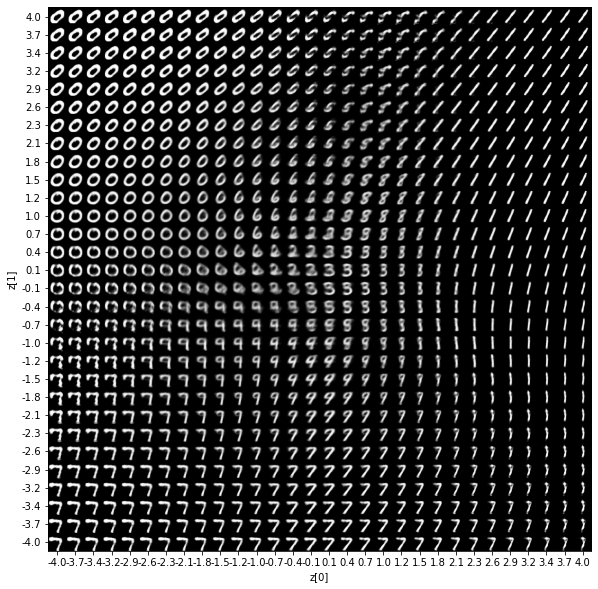

In [ ]:
plot_latent(encoder, decoder, 4, 30) 

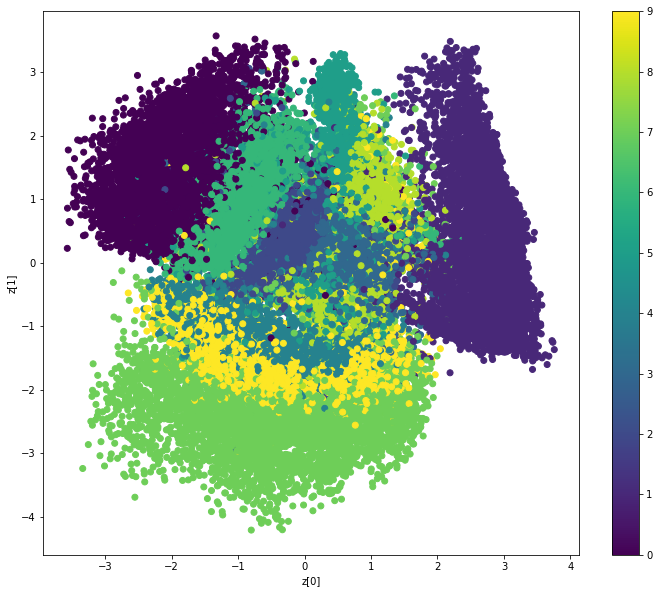

In [ ]:
plot_label_clusters(encoder, decoder, x_train, y_train)

In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = layers.Dense(256, activation="relu")(encoder_inputs)
x = layers.Dense(170, activation="relu")(x)
x = layers.Dense(110, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
z_mean =  layers.Dense(units = latent_dim, name = "z_mean")(x)
z_var =  layers.Dense(latent_dim, name = "z_var")(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(110, activation="relu")(latent_inputs)
x = layers.Dense(170, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

print("Number of encoder parameters: ", encoder.count_params())
print("Number of decoder parameters: ", decoder.count_params())

Number of encoder parameters:  270824
Number of decoder parameters:  264464


In [ ]:
vae_4 = VAE(encoder, decoder)
vae_4.compile(optimizer=keras.optimizers.Adam())
vae_4.fit(x_train, x_train, epochs=25, batch_size=80)

Epoch 1/25
625/625 [==============================] - 9s 13ms/step - loss: 188.4857 - reconstruction_loss: 184.2312 - kl_loss: 4.2545
Epoch 2/25
625/625 [==============================] - 8s 13ms/step - loss: 162.7457 - reconstruction_loss: 157.7454 - kl_loss: 5.0003
Epoch 3/25
625/625 [==============================] - 8s 13ms/step - loss: 156.3131 - reconstruction_loss: 150.8489 - kl_loss: 5.4641
Epoch 4/25
625/625 [==============================] - 8s 13ms/step - loss: 152.7289 - reconstruction_loss: 147.0022 - kl_loss: 5.7266
Epoch 5/25
625/625 [==============================] - 8s 13ms/step - loss: 150.3642 - reconstruction_loss: 144.4623 - kl_loss: 5.9019
Epoch 6/25
625/625 [==============================] - 8s 13ms/step - loss: 148.2801 - reconstruction_loss: 142.2286 - kl_loss: 6.0515
Epoch 7/25
625/625 [==============================] - 8s 13ms/step - loss: 147.1680 - reconstruction_loss: 141.0108 - kl_loss: 6.1572
Epoch 8/25
625/625 [==============================] - 8s 13ms/

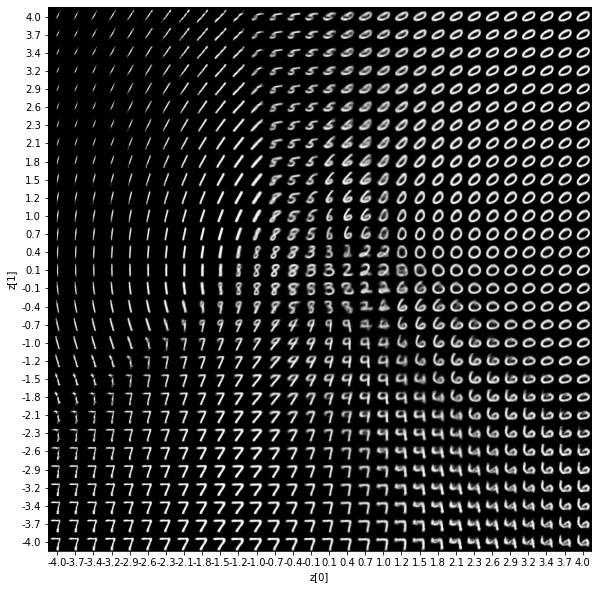

In [ ]:
plot_latent(encoder, decoder, 4.0, 30) 

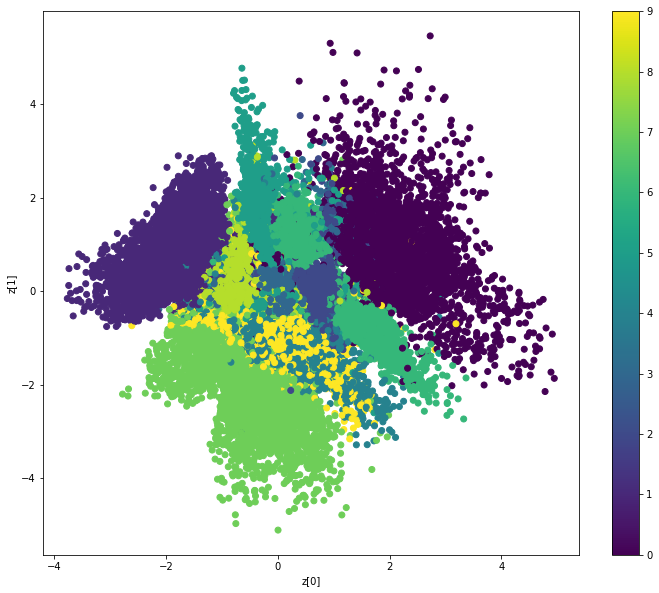

In [ ]:
plot_label_clusters(encoder, decoder, x_train, y_train)

I varied model complexity through number of
layers L of deterministic hidden units, and number of hidden units H_i in each layer. 
- for a fixed network depth L, if I double the number of active units of the first layer it has a the model has a slight better classifying confidence. In fact it is visible from the more compact clustering and less fuzzy borders on the plot
- A negligible effect is instead obtained by increasing the depth of the decoder L=4, with same number of hidden units for the first layer and last layer. This model can be considered equivalent than the original one except for the number of parameters and training time that are higher, for this reason the first one is preferable.
- A more evident deterioration in performance is instead observable decreasing the depth L of the network and keeping the number of units of first and last layer fixed. The worsening of the performance is given by the reconstruction loss term which has visibly increased, meaning the decoded samples less match the initial inputs. The worsening of the result is also visible by the plot of latent space representation where the distribution shows a less centering in the origin and digit separation boundaries are less distinguishable.

